In [219]:
import os

import pandas as pd

%matplotlib inline
from CheXpert2 import names
import cv2
from CheXpert2.dataloaders.CXRLoader import CXRLoader
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image

# Step 1 : Initiating the dataset

Since we don't train the model, we only need one dataset

In [220]:
img_dir="/mnt/c/Users/bejo2361/PycharmProjects/IA-MED_IMG"
os.environ["DEBUG"]="False"
dataset = CXRLoader(
            split="Train",
            img_dir=img_dir,
            img_size=224,
            prob=[0,0,0,0,0,0],
            intensity=0,
            label_smoothing=0,
            channels=1,
            use_frontal=False,
            datasets=["ChexPert"]
        )
i=0

/mnt/c/Users/bejo2361/PycharmProjects/IA-MED_IMG/CheXpert2/dataloaders/CXRLoader.py:179: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  data = data[self.classes]


# Step 2 : Assert the dataloader is working ; Require the images on the device

torch.Size([2, 224, 224])
254
0


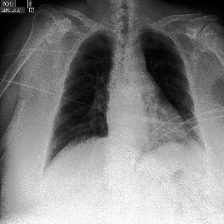

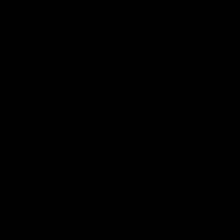

torch.Size([2, 224, 224])
255
255


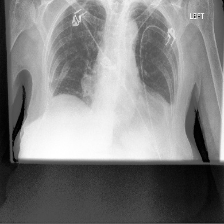

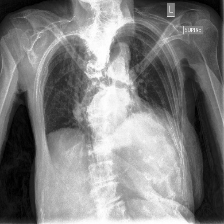

torch.Size([2, 224, 224])
255
0


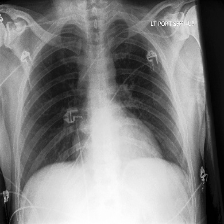

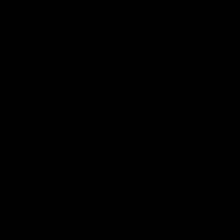

torch.Size([2, 224, 224])
255
255


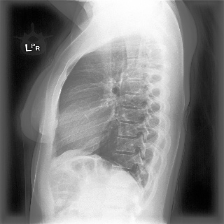

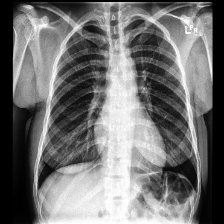

torch.Size([2, 224, 224])
255
255


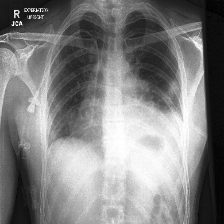

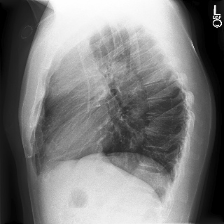

torch.Size([2, 224, 224])
255
0


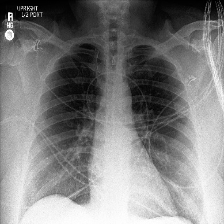

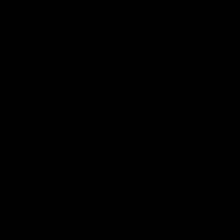

torch.Size([2, 224, 224])
255
255


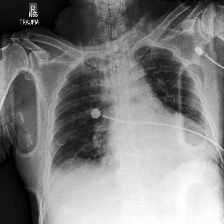

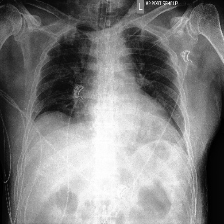

torch.Size([2, 224, 224])
255
255


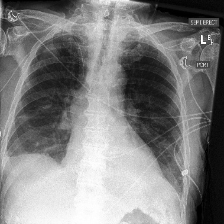

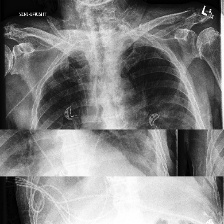

torch.Size([2, 224, 224])
255
255


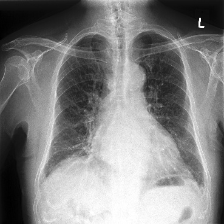

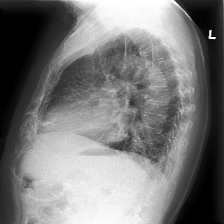

torch.Size([2, 224, 224])
255
255


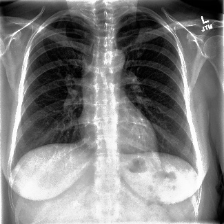

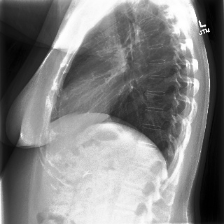

In [221]:
import time
for i in range(0,10) :
    images,label,idx = dataset[i]
    print(images.shape)
    frontal,lateral =   images[0,:,:].numpy().astype(np.uint8),images[1,:,:].numpy().astype(np.uint8)
    #frontal,lateral = cv2.cvtColor(frontal[:,:,None],cv2.COLOR_GRAY2RGB),cv2.cvtColor(lateral[:,:,None],cv2.COLOR_GRAY2RGB)
    print(np.max(frontal))
    print(np.max(lateral))
    frontal_image = Image.fromarray(frontal)
    lateral_image = Image.fromarray(lateral)
    frontal_image.show()
    lateral_image.show()


# Step 2.2 : We can test the data augmentations !

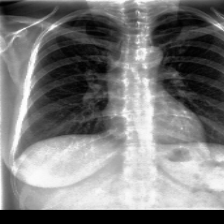

In [222]:
import albumentations as A
import cv2 as cv
#image  = A.augmentations.geometric.transforms.Affine(scale=(0.95,1.05),translate_percent=(0.05,0.05),rotate=(-15,15),shear=None,cval=0,keep_ratio=True,p=1)(image=np.array(frontal_image)[:,:,None])["image"]

# image  = A.augmentations.transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.4, always_apply=False,p=1)(image=np.array(frontal_image)[:,:,None])["image"]

image = A.GridDistortion(num_steps=1,distort_limit=0.3,interpolation=1,border_mode=0,value=None,mask_value=None,always_apply=False,p=1)(image=np.array(frontal_image)[:,:,None])["image"]

# image = A.ElasticTransform(alpha=0.2, sigma=25, alpha_affine=50, interpolation=1, value=None,p=1, border_mode=cv.BORDER_CONSTANT)(image=np.array(frontal_image)[:,:,None])["image"]

image = Image.fromarray(image.squeeze())

image.show()

# Step 3 : Let's now plot some information about the dataset

In [223]:

data = np.concatenate([dataset.count.reshape((1,18)),dataset.count.reshape((1,18))/len(dataset)])
data = pd.DataFrame(data,columns=names,index=["Count","Ratio"])
print(data)


            Opacity          Air       Liquid  Cardiomegaly  Lung Lesion  \
Count  21754.000000  3635.000000  29833.00000    5504.00000  2312.000000   
Ratio      0.337062     0.056322      0.46224       0.08528     0.035823   

       Emphysema         Edema  Consolidation  Atelectasis  Pneumothorax  \
Count        0.0  10755.000000    2342.000000  7690.000000   3122.000000   
Ratio        0.0      0.166641       0.036288     0.119151      0.048373   

       Pleural Effusion     Fracture  Hernia  Infiltration  Mass  Nodule  \
Count       17562.00000  2745.000000     0.0           0.0   0.0     0.0   
Ratio           0.27211     0.042532     0.0           0.0   0.0     0.0   

       Pneumo other   No Finding  
Count           0.0  8509.000000  
Ratio           0.0     0.131841  


In [224]:
plt.bar(x=range(0,len(names)),height=dataset.count,label=names)
plt.show()

<IPython.core.display.Javascript object>

# Let's now verify the dataloader ; does it extract the classes as we want to?

The ratio of images with a second image :  0.34987604586303067


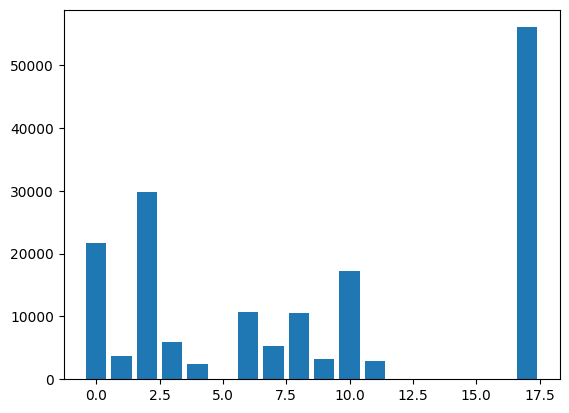

In [227]:
import torch
%matplotlib inline
second_image_count=0


labels=torch.zeros((len(names)))

for image,label,idx in dataset :
    if torch.max(image[1])==0 :
        second_image_count+=1

    labels+=label

print("The ratio of images with a second image : ", second_image_count/len(dataset))
plt.bar(x=range(0,len(names)),height=labels,label=names)
plt.show()